To run this notebook, please select julia as the default interpreter!

In [1]:
# Import some libraries
include("LargeSystems/system.jl")
include("Utils/Layered.jl")
include("evaluation-tools.jl")

# Set our domain constants
const L::Float64 = 10.0
const tf::Float64 = .1

0.1

Below is the code to build a upwind/downwind system

In [17]:
function build_system(M::Integer, N::Integer, u0::Function, a::Float64, tf::Float64)
    # Build the system over an M×N grid
    Δx = L / (M + 1)
    Δt = tf / (N + 1)

    # Initialize the variables and the system
    U = ["U$j,$n" for j in range(1, M+1), n in range(1, N+1)]
    system = System(U)
    U = Layered{Tuple{Integer, Integer}, Union{Linear, Number}}([V(U[j,n]) for j in range(1, M+1), n in range(1, N+1)])

    # Initial conditions
    for j in range(0, M + 2)
        U[j, 0] = u0(Δx * j)
    end

    # Initialize our boundary
    for n in range(1, N + 1)
        U[0, n] = U[M + 1, n]
        U[M + 2, n] = U[1, n]
    end

    # Now, we add our schema
    if a >= 0
        # Upwind!
        for n in range(0, N)
            for j in range(1, M+1)
                add_constraint!(system, U[j,n+1] == U[j,n] - a * Δt/Δx * (U[j,n] - U[j-1,n]))
            end
        end
    else
        # Downwind!
        for n in range(0, N)
            for j in range(1, M+1)
                add_constraint!(system, U[j,n+1] == U[j,n] - a * Δt/Δx * (U[j+1,n] - U[j,n]))
            end
        end
    end

    return system
end

build_system (generic function with 1 method)

First, lets look what happens for a = 20, and with a smooth bell function

┌ Info: Saved animation to c:\Users\Atech\Dropbox\Numerical PDEs\HW\HW3 Files\LargeSystems-Julia\a=20,upwind.gif
└ @ Plots C:\Users\Atech\.julia\packages\Plots\HyyIK\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\Atech\\Dropbox\\Numerical PDEs\\HW\\HW3 Files\\LargeSystems-Julia\\a=20,upwind.gif")
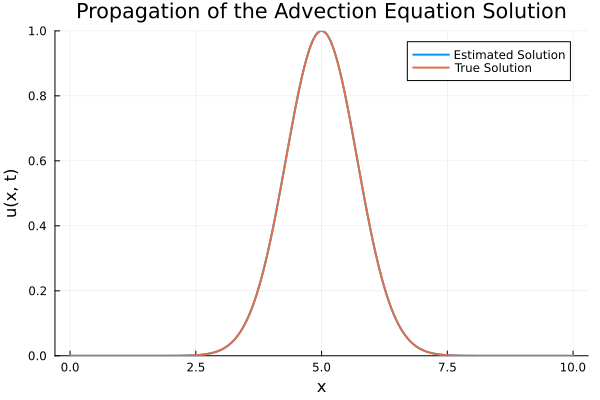

In [7]:
# First, lets take a look at our solution where u0 is a bell
u0(x::Float64) = exp(-(x-L/2)^2)

# To avoid boilerplate, create a plugin
a = 20.0
tf = .1
plug = plugin(u0, a, tf)

# Now, we can plot the solution
solution = plug(solve_system)(build_system, 400, 100)
plug(plot_solution)(solution, "a=20,upwind.gif")

And now for negative velocity:

┌ Info: Saved animation to c:\Users\Atech\Dropbox\Numerical PDEs\HW\HW3 Files\LargeSystems-Julia\a=-20,downwind.gif
└ @ Plots C:\Users\Atech\.julia\packages\Plots\HyyIK\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\Atech\\Dropbox\\Numerical PDEs\\HW\\HW3 Files\\LargeSystems-Julia\\a=-20,downwind.gif")
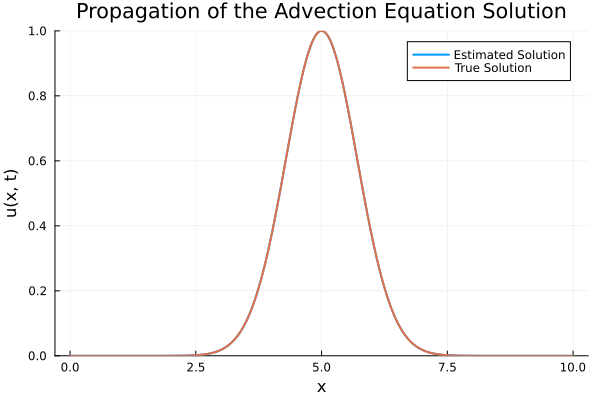

In [9]:
# Lets try for a = -20
a = -20.0
plug = plugin(u0, a, tf)

# Plot the solution
solution = plug(solve_system)(build_system, 400, 100)
plug(plot_solution)(solution, "a=-20,downwind.gif")

And lets see what our order of convergence is...

In [10]:
evaluate_Ns(build_system, u0, a, tf, 30, 40, 50, 60, 70, 80, 90, 100)

[0.006359429375345959, 0.00468962473757915, 0.0037117964741542873, 0.003070452953008004, 0.002617681571431818, 0.0022810837540910194, 0.0020210807767457465, 0.0018142236513097108]
The estimated order of convergence was 1.060653800189223


This corresponds to $O(n)$ convergence, not great. Now, lets add some shock to our solution:

┌ Info: Saved animation to c:\Users\Atech\Dropbox\Numerical PDEs\HW\HW3 Files\LargeSystems-Julia\a=20,shock.gif
└ @ Plots C:\Users\Atech\.julia\packages\Plots\HyyIK\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\Atech\\Dropbox\\Numerical PDEs\\HW\\HW3 Files\\LargeSystems-Julia\\a=20,shock.gif")
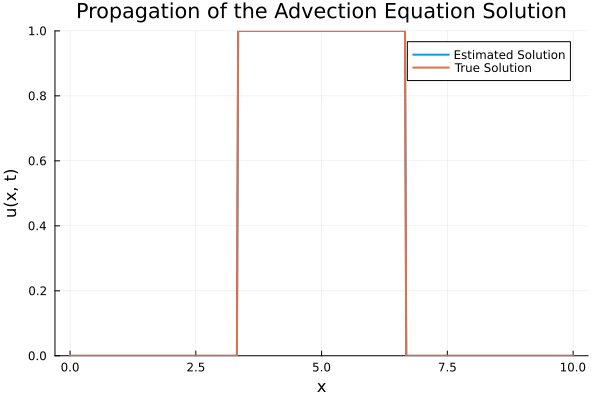

In [12]:
# Lets try a solution with some shock
u0(x::Float64) = L/3 < x < 2L/3 ? 1.0 : 0.0
a = 20.0
plug = plugin(u0, a, tf)

# Plot the solution
solution = plug(solve_system)(build_system, 400, 100)
plug(plot_solution)(solution, "a=20,shock.gif")

and with negative velocity:

┌ Info: Saved animation to c:\Users\Atech\Dropbox\Numerical PDEs\HW\HW3 Files\LargeSystems-Julia\a=-20,shock.gif
└ @ Plots C:\Users\Atech\.julia\packages\Plots\HyyIK\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\Atech\\Dropbox\\Numerical PDEs\\HW\\HW3 Files\\LargeSystems-Julia\\a=-20,shock.gif")
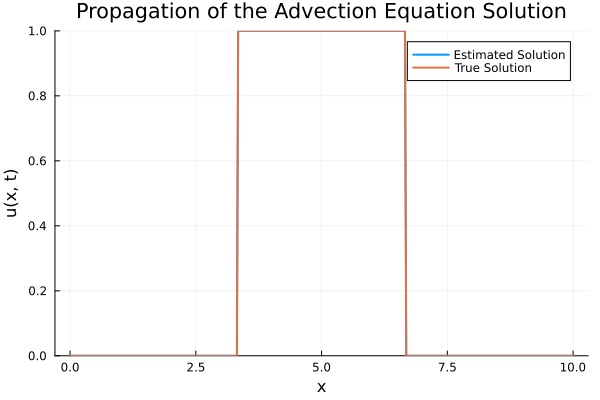

In [18]:
# Lets try for a = -20
a = -20.0
plug = plugin(u0, a, tf)

# Plot the solution
solution = plug(solve_system)(build_system, 400, 100)
plug(plot_solution)(solution, "a=-20,shock.gif")

We can see that the solution smooths out around the shocks. Now lets check the convergence after adding the shock.

In [19]:
evaluate_Ns(build_system, u0, a, tf, 30, 40, 50, 60, 70, 80, 90, 100)

[0.0791137811140421, 0.07287817943737725, 0.07201329888547822, 0.06503985945422656, 0.062398527070040156, 0.062320298086764946, 0.05829321731474551, 0.056669456323063354]
The estimated order of convergence was 0.28207627413639763
